To test print a lattice structure, we won't use streaming for now, until we can figure out the triggering.

Instead we will load in a single repeating unit for a square lattice structure.

On each trigger it will go to the next one and repeat indefinitely

The following will output 63 pulses across each line

In [137]:
import nifgen
import time
import numpy as np

# parameters
cycles = 60
cycle_duration = 1e-6       # each square cycle is 20 µs
sample_rate = 100e6          # 100 MHz AWG clock

# number of samples per 20 µs cycle
samples_per_cycle = int(cycle_duration * sample_rate)

# build one 50%-duty square cycle (high half, low half)
one_cycle = np.concatenate([
    np.ones(samples_per_cycle // 2),
    np.zeros(samples_per_cycle - samples_per_cycle // 2)
])

# repeat it 3 times in a row
wf = np.tile(one_cycle, cycles)


with nifgen.Session("Dev1") as session:
    # set up ARB mode
    session.output_mode = nifgen.OutputMode.ARB
    session.arb_sample_rate = sample_rate

    # upload our 3×20 µs burst
    wf_handle = session.create_waveform(wf)

    # trigger config: one burst per rising edge on PFI1
    session.start_trigger_type = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge = (
        nifgen.StartTriggerDigitalEdgeEdge.RISING
    )
    session.trigger_mode = nifgen.TriggerMode.STEPPED

    # tie the arb into the output
    session.configure_arb_waveform(wf_handle, gain=0.5, offset=0)

    session.initiate()
    # now each PFI1 rising edge → three 20 µs square pulses
    time.sleep(5)


This is a single waveform generator. A single "pulse". 

This can then be used in a sequence generator

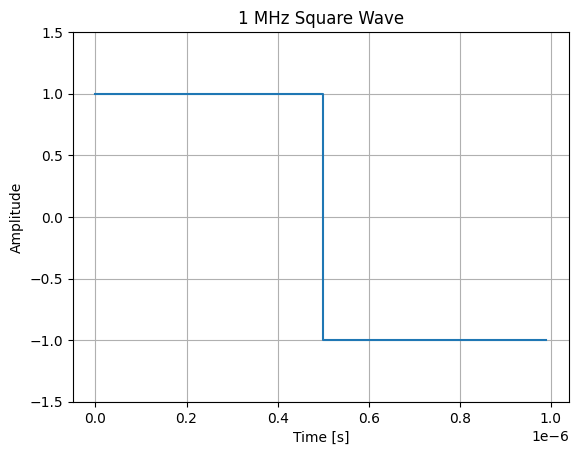

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
frequency = 1e6         # Hz
sampling_rate = 100_000_000  # Samples per second
duration = 1e-6         # Seconds

# Time array
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Square wave: +1 when sine ≥ 0, –1 when sine < 0
square_wave = np.where(
    np.sin(2 * np.pi * frequency * t) >= 0,
    1.0,
    -1.0
).astype(np.float64)


zero_wave = np.where(
    np.sin(2 * np.pi * frequency * t) >= 0,
    -1.0,
    -1.0
).astype(np.float64)


# Plot
plt.plot(t, square_wave, drawstyle='steps-pre')
plt.title("1 MHz Square Wave")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.ylim(-1.5, 1.5)
plt.show()


In [125]:
with nifgen.Session("Dev1") as session:
    session.output_mode = nifgen.OutputMode.SEQ
    session.arb_sample_rate = 100_000_000
    session.streaming_write_timeout = 30.0

    # Get handles for location of waveform in memory
    square_handle = session._create_waveform_f64_numpy(square_wave)
    
    # Create waveform handle array and loop counts for sequence
    waveform_handle_array = []
    loop_counts = []

    # Adding a single pixel to each line and going back down to 1
    for i in range(63):
        waveform_handle_array.append(square_handle)
        loop_counts.append(i + 1)  # 1 to 64

    for i in range(63):
        waveform_handle_array.append(square_handle)
        loop_counts.append(64 - i)  # 64 to 1


    # Load waveform handle array and loop counts to make a sequence
    sequence_handle = session.create_arb_sequence(waveform_handle_array, loop_counts)

    # Configuring the sequence with the sequence handle
    session.configure_arb_sequence(sequence_handle, 0.5, 0)

    # Add a trigger to start the next waveform
    session.start_trigger_type                = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge   = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode                      = nifgen.TriggerMode.STEPPED

    # Initiate session
    session.initiate()
    time.sleep(10)

In [124]:
with nifgen.Session("Dev1") as session:
    session.output_mode = nifgen.OutputMode.SEQ
    session.arb_sample_rate = 100_000_000
    session.streaming_write_timeout = 30.0

    # Get handles for location of waveform in memory
    square_handle = session._create_waveform_f64_numpy(square_wave)

    num_triangles = 4  # triangles per line
    max_width = 64     # maximum total width of the line
    triangle_height = 20

    waveform_handle_array = []
    loop_counts = []

    for i in range(triangle_height):
        width = i + 1  # increasing width for the triangle
        spacing = (max_width - num_triangles * width) // (num_triangles + 1)

        for _ in range(num_triangles):
            waveform_handle_array.append(square_handle)
            loop_counts.append(width)

        # You could also track spacing positions here if needed
    for i in range(triangle_height):
        width = triangle_height - i  # decreasing width for the triangle
        spacing = (max_width - num_triangles * width) // (num_triangles + 1)

        for _ in range(num_triangles):
            waveform_handle_array.append(square_handle)
            loop_counts.append(width)


    # Load waveform handle array and loop counts to make a sequence
    sequence_handle = session.create_arb_sequence(waveform_handle_array, loop_counts)

    # Configuring the sequence with the sequence handle
    session.configure_arb_sequence(sequence_handle, 0.5, 0)

    # Add a trigger to start the next waveform
    session.start_trigger_type                = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge   = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode                      = nifgen.TriggerMode.STEPPED

    # Initiate session
    session.initiate()
    time.sleep(3)

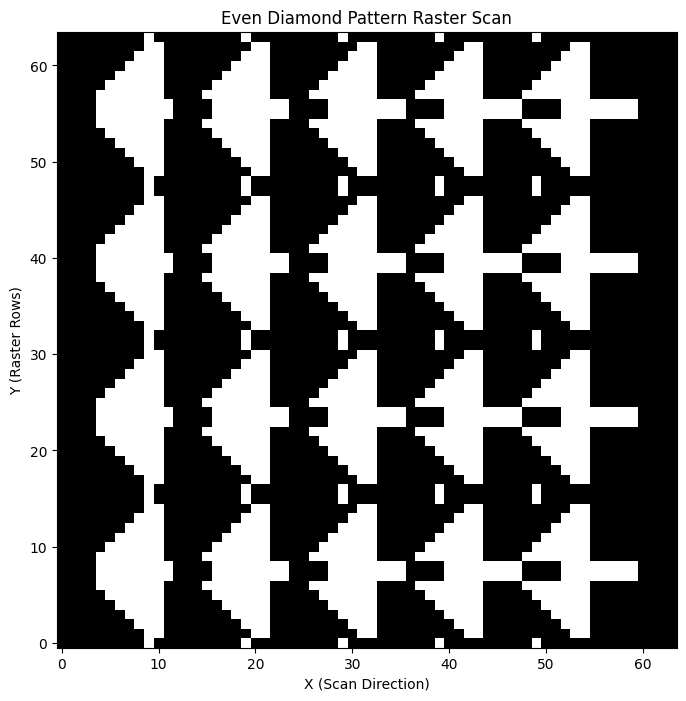

In [138]:
# Build a perfectly symmetric diamond by generating a single triangle and mirroring it

# Parameters
triangle_height = 8
num_triangles = 5
max_width = 64

# Generate upward triangle block (ascending width)
def generate_block(triangle_height, num_triangles, max_width):
    block = []
    for i in range(triangle_height):
        width = i + 1
        spacing = (max_width - num_triangles * width) // (num_triangles + 1)
        row = [0] * max_width
        for t in range(num_triangles):
            start = spacing * (t + 1) + width * t
            end = start + width
            if end <= max_width:
                row[start:end] = [1] * width
        block.append(row)
    return block

# Make upward and downward triangle halves
up_block = generate_block(triangle_height, num_triangles, max_width)
down_block = up_block[::-1]  # invert vertically for symmetry

# Combine into a diamond and repeat
diamond = up_block + down_block
num_repeats = 4  # number of vertical repeats
scan_pattern = diamond * num_repeats

# Convert to NumPy array and plot
scan_pattern = np.array(scan_pattern).astype(np.float64)

plt.figure(figsize=(8, 8))
plt.imshow(scan_pattern, cmap='gray', aspect='auto', origin='lower')
plt.title("Even Diamond Pattern Raster Scan")
plt.xlabel("X (Scan Direction)")
plt.ylabel("Y (Raster Rows)")
plt.grid(False)
plt.show()


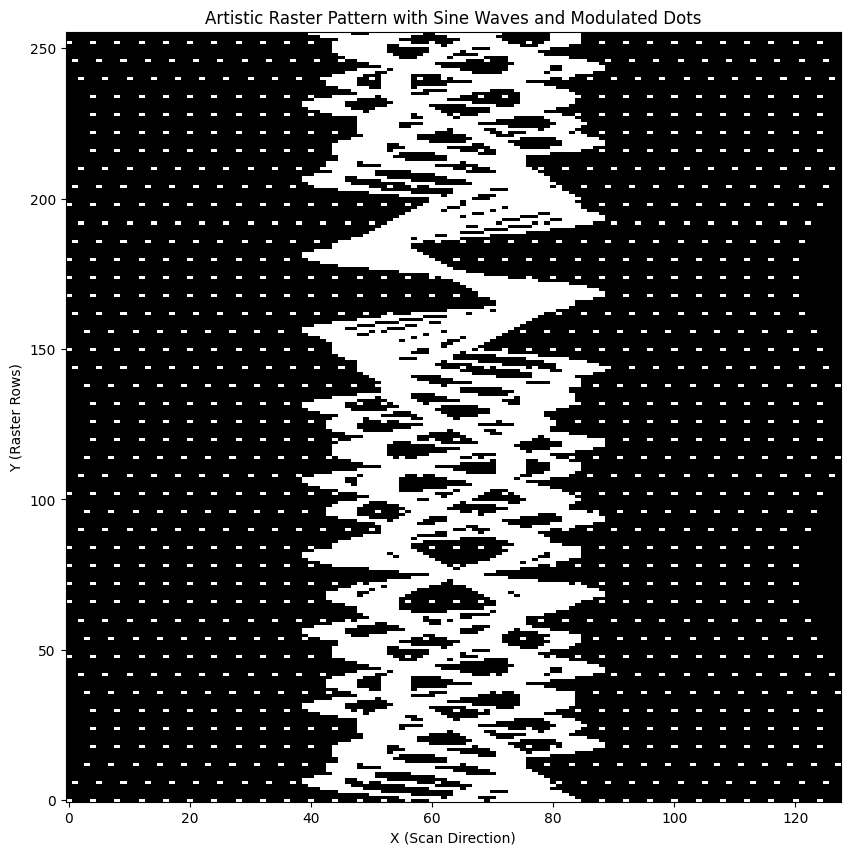

In [103]:
# Let's create an artistic pattern by layering sine wave curves with variable phase and amplitude
# We'll also use a density-based dot matrix approach to add a visual rhythm

height, width = 256, 128
pattern = np.zeros((height, width))

# Base sine wave parameters
num_waves = 5
for i in range(num_waves):
    amplitude = 10 + i * 3
    frequency = 0.02 + i * 0.005
    phase_shift = i * np.pi / 4

    for y in range(height):
        x_center = int((width // 2) + amplitude * np.sin(2 * np.pi * frequency * y + phase_shift))
        dot_radius = 2 + (i % 3)

        # Draw a dot around the center x-coordinate
        for dx in range(-dot_radius, dot_radius + 1):
            x = x_center + dx
            if 0 <= x < width:
                pattern[y, x] = 1

# Add horizontal stripes modulated by sine wave to overlay
for y in range(0, height, 6):
    offset = int(5 * np.sin(2 * np.pi * 0.01 * y))
    for x in range(0, width, 4):
        if 0 <= x + offset < width:
            pattern[y, x + offset] = 1

# Plot the artistic pattern
plt.figure(figsize=(10, 10))
plt.imshow(pattern, cmap='gray', aspect='auto', origin='lower')
plt.title("Artistic Raster Pattern with Sine Waves and Modulated Dots")
plt.xlabel("X (Scan Direction)")
plt.ylabel("Y (Raster Rows)")
plt.grid(False)
plt.show()


In [139]:
# Re-import libraries after environment reset
import numpy as np
import matplotlib.pyplot as plt

# Recreate the artistic pattern
height, width = 256, 128
pattern = np.zeros((height, width))

# Base sine wave parameters
num_waves = 5
for i in range(num_waves):
    amplitude = 10 + i * 3
    frequency = 0.02 + i * 0.005
    phase_shift = i * np.pi / 4

    for y in range(height):
        x_center = int((width // 2) + amplitude * np.sin(2 * np.pi * frequency * y + phase_shift))
        dot_radius = 2 + (i % 3)
        for dx in range(-dot_radius, dot_radius + 1):
            x = x_center + dx
            if 0 <= x < width:
                pattern[y, x] = 1

# Add modulated horizontal stripes
for y in range(0, height, 6):
    offset = int(5 * np.sin(2 * np.pi * 0.01 * y))
    for x in range(0, width, 4):
        if 0 <= x + offset < width:
            pattern[y, x + offset] = 1

# Convert each row into its own np.float64 array
pattern_rows_as_arrays = [np.array(row, dtype=np.float64) for row in pattern]

# Display a few examples
pattern_rows_as_arrays[:3]


[array([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.